For this exercise, I am working with a fairly large dataset about retail purchases, to try to understand consumer behaviour.

In [2]:
import pandas as pd

df = pd.read_csv('retail_data.csv')
df.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,...,324.086270,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts
1,2174773.0,69749.0,Kelsey Hill,Mark36@gmail.com,6.852900e+09,82072 Dawn Centers,Nottingham,England,99071.0,UK,...,806.707815,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.0,Lenovo Tab
2,6679610.0,30192.0,Scott Jensen,Shane85@gmail.com,8.362160e+09,4133 Young Canyon,Geelong,New South Wales,75929.0,Australia,...,1063.432799,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.0,Sports equipment
3,7232460.0,62101.0,Joseph Miller,Mary34@gmail.com,2.776752e+09,8148 Thomas Creek Suite 100,Edmonton,Ontario,88420.0,Canada,...,2466.854021,Home Decor,Home Depot,Tools,Excellent,Standard,PayPal,Processing,4.0,Utility knife
4,4983775.0,27901.0,Debra Coleman,Charles30@gmail.com,9.098268e+09,5813 Lori Ports Suite 269,Bristol,England,48704.0,UK,...,248.553049,Grocery,Nestle,Chocolate,Bad,Standard,Cash,Shipped,1.0,Chocolate cookies


There is a lot of categorical data in this dataset, so a lot of columns need to be encoded.

In [4]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['Name', 'Email', 'Phone', 'Address', 'City', 'State', 'Country', 'Gender', 'Income', 
                     'Customer_Segment', 'Month', 'Product_Category', 'Product_Brand', 'Product_Type', 
                     'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status', 'products']

le = LabelEncoder()

for column in columns_to_encode:
    df[column] = le.fit_transform(df[column])

df.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,109110,16503,13801,118307,35,4,77985.0,2,...,324.086270,1,10,23,2,1,2,3,5.0,86
1,2174773.0,69749.0,86175,35163,194622,245491,87,9,99071.0,3,...,806.707815,2,14,28,2,2,1,2,4.0,164
2,6679610.0,30192.0,135685,44930,245087,123528,46,33,75929.0,0,...,1063.432799,0,11,3,0,1,1,2,2.0,268
3,7232460.0,62101.0,77466,35499,58892,243686,40,39,88420.0,1,...,2466.854021,4,6,31,2,2,3,2,4.0,301
4,4983775.0,27901.0,41207,9581,269425,173832,20,9,48704.0,3,...,248.553049,3,9,4,1,2,0,3,1.0,58


The dates are also very inconsistently formatted, so the following code aims to homogenize the dates into a single format.

In [11]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)
df = df.dropna(subset=['Date'])

df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'].head(10)

C:\Users\Jan\AppData\Local\Temp\ipykernel_20052\639577184.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)


0     2023-09-18
1     2023-12-31
2     2023-04-26
5     2023-09-21
6     2023-06-26
7     2023-03-24
10    2023-07-20
11    2023-06-21
14    2023-11-18
15    2023-06-15
Name: Date, dtype: object

Here we cluster the data in an RFM analysis, in an attempt to better understand the different types of customers the business has.

In [6]:
from sklearn.cluster import KMeans
import numpy as np

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

rfm_df = df.groupby('Customer_ID').agg({
    'Date': lambda x: (df['Date'].max() - x.max()).days,
    'Customer_ID': 'count',
    'Total_Amount': 'sum'
}).rename(columns={'Date': 'Recency', 'Customer_ID': 'Frequency', 'Total_Amount': 'Monetary'})

rfm_df['Recency'] = rfm_df['Recency'] / rfm_df['Recency'].max()
rfm_df['Frequency'] = rfm_df['Frequency'] / rfm_df['Frequency'].max()
rfm_df['Monetary'] = rfm_df['Monetary'] / rfm_df['Monetary'].max()

kmeans = KMeans(n_clusters=4)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

rfm_df.head()

,Recency,Frequency,Monetary,Cluster
Customer_ID,,,,
10000.0,0.288952,0.4,0.228323,3
10001.0,0.294618,0.4,0.194097,3
10002.0,0.266289,0.4,0.170853,3
10003.0,0.643059,0.1,0.086209,1
10004.0,0.084986,0.1,0.070268,0


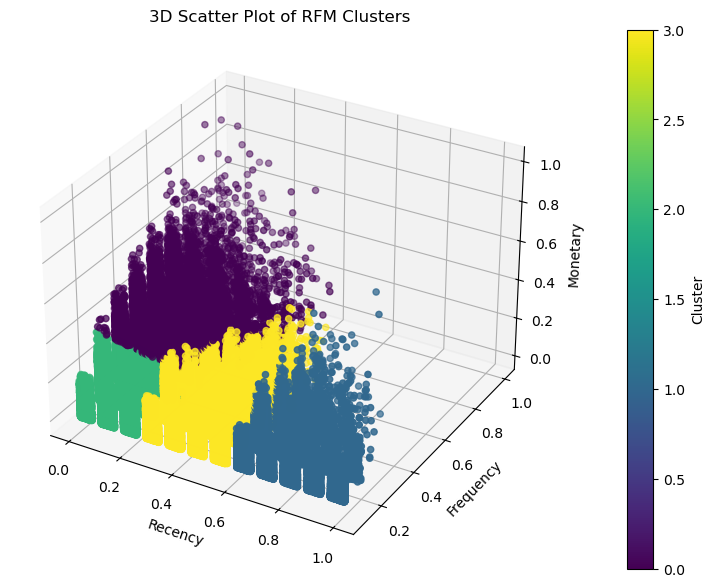

In [25]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(rfm_df['Recency'], rfm_df['Frequency'], rfm_df['Monetary'], c=rfm_df['Cluster'], cmap='viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clusters')

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster')

plt.show()

There seems to be mostly a split into recency. There is quite some value to be found in both the very recent customers who seem to have decent monetary totals, and the cluster with high frequency and monetary totals, who may need to be dragged back into the business in some way, due to the tendency towards low recency.